In [1]:
suppressMessages(library('ggplot2'))
suppressMessages(library('ggthemes')) 
suppressMessages(library('scales')) 
suppressMessages(library('dplyr'))
suppressMessages(library('randomForest'))
suppressMessages(library('corrplot'))
suppressMessages(library('plyr'))


In [4]:
#Loading Data

train <- read.csv('train.csv', stringsAsFactors = F)
test  <- read.csv('test.csv', stringsAsFactors = F)


In [5]:
full  <- bind_rows(train, test) # test + train

options( warn = -1 )

In [6]:
str(full)

'data.frame':	1309 obs. of  12 variables:
 $ PassengerId: int  1 2 3 4 5 6 7 8 9 10 ...
 $ Survived   : int  0 1 1 1 0 0 0 0 1 1 ...
 $ Pclass     : int  3 1 3 1 3 3 1 3 3 2 ...
 $ Name       : chr  "Braund, Mr. Owen Harris" "Cumings, Mrs. John Bradley (Florence Briggs Thayer)" "Heikkinen, Miss. Laina" "Futrelle, Mrs. Jacques Heath (Lily May Peel)" ...
 $ Sex        : chr  "male" "female" "female" "female" ...
 $ Age        : num  22 38 26 35 35 NA 54 2 27 14 ...
 $ SibSp      : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch      : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Ticket     : chr  "A/5 21171" "PC 17599" "STON/O2. 3101282" "113803" ...
 $ Fare       : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Cabin      : chr  "" "C85" "" "C123" ...
 $ Embarked   : chr  "S" "C" "S" "S" ...


In [7]:
summary(full)

  PassengerId      Survived          Pclass          Name          
 Min.   :   1   Min.   :0.0000   Min.   :1.000   Length:1309       
 1st Qu.: 328   1st Qu.:0.0000   1st Qu.:2.000   Class :character  
 Median : 655   Median :0.0000   Median :3.000   Mode  :character  
 Mean   : 655   Mean   :0.3838   Mean   :2.295                     
 3rd Qu.: 982   3rd Qu.:1.0000   3rd Qu.:3.000                     
 Max.   :1309   Max.   :1.0000   Max.   :3.000                     
                NA's   :418                                        
     Sex                 Age            SibSp            Parch      
 Length:1309        Min.   : 0.17   Min.   :0.0000   Min.   :0.000  
 Class :character   1st Qu.:21.00   1st Qu.:0.0000   1st Qu.:0.000  
 Mode  :character   Median :28.00   Median :0.0000   Median :0.000  
                    Mean   :29.88   Mean   :0.4989   Mean   :0.385  
                    3rd Qu.:39.00   3rd Qu.:1.0000   3rd Qu.:0.000  
                    Max.   :80.00   Max.  

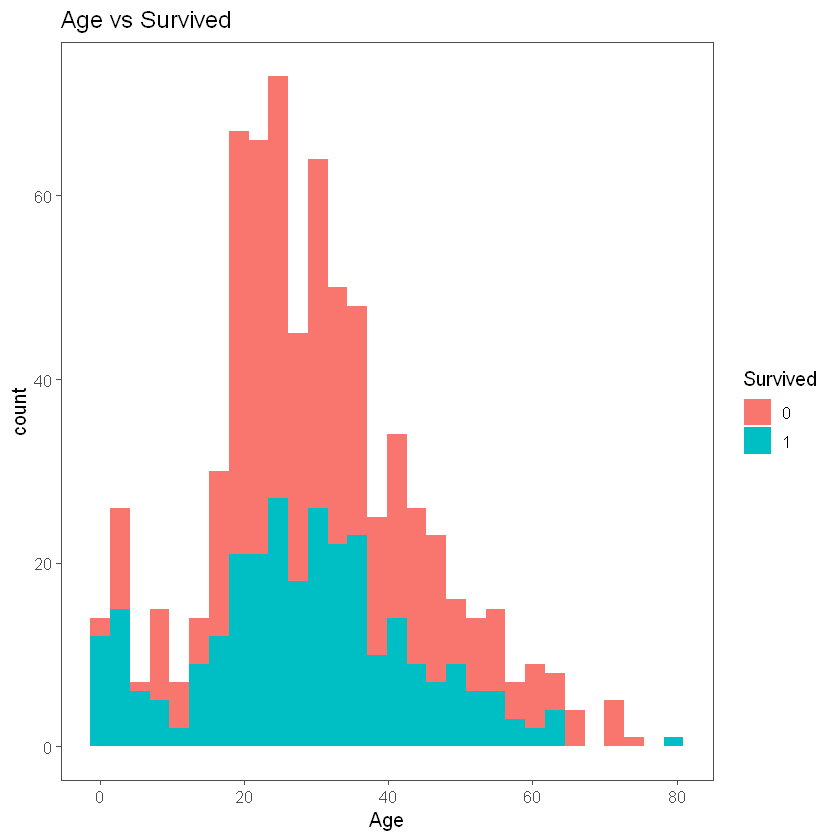

In [8]:
ggplot(full[1:891,], aes(Age, fill = factor(Survived))) + 
  geom_histogram(bins=30) + 
  theme_few() +
  xlab("Age") +
  scale_fill_discrete(name = "Survived") + 
  ggtitle("Age vs Survived")

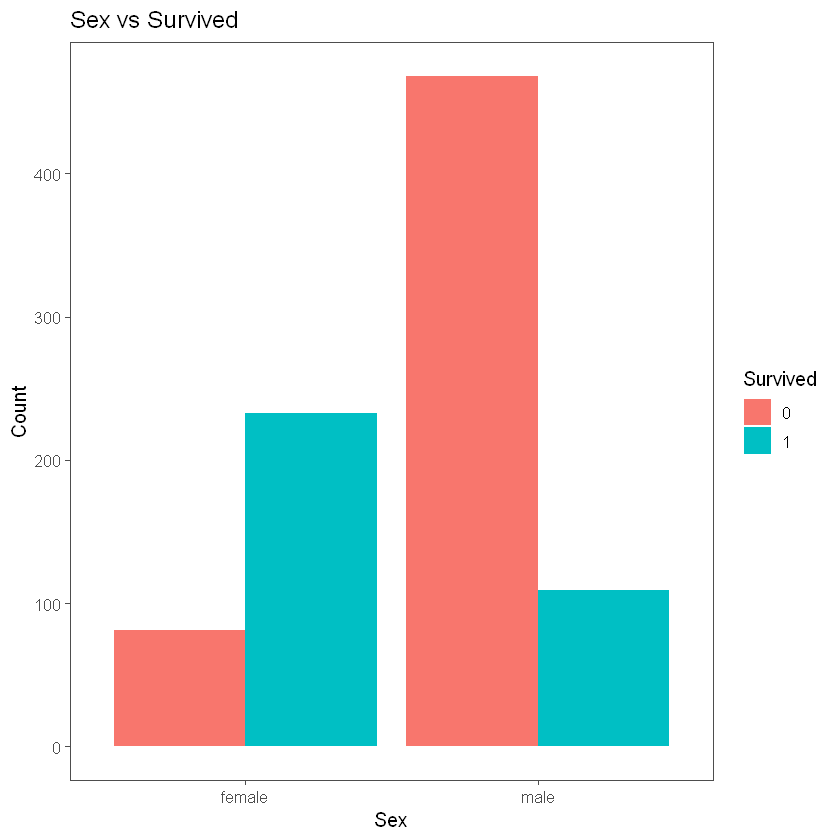

In [9]:
ggplot(full[1:891,], aes(Sex, fill = factor(Survived))) + 
  geom_bar(stat = "count", position = 'dodge')+
  theme_few() +
  xlab("Sex") +
  ylab("Count") +
  scale_fill_discrete(name = "Survived") + 
  ggtitle("Sex vs Survived")

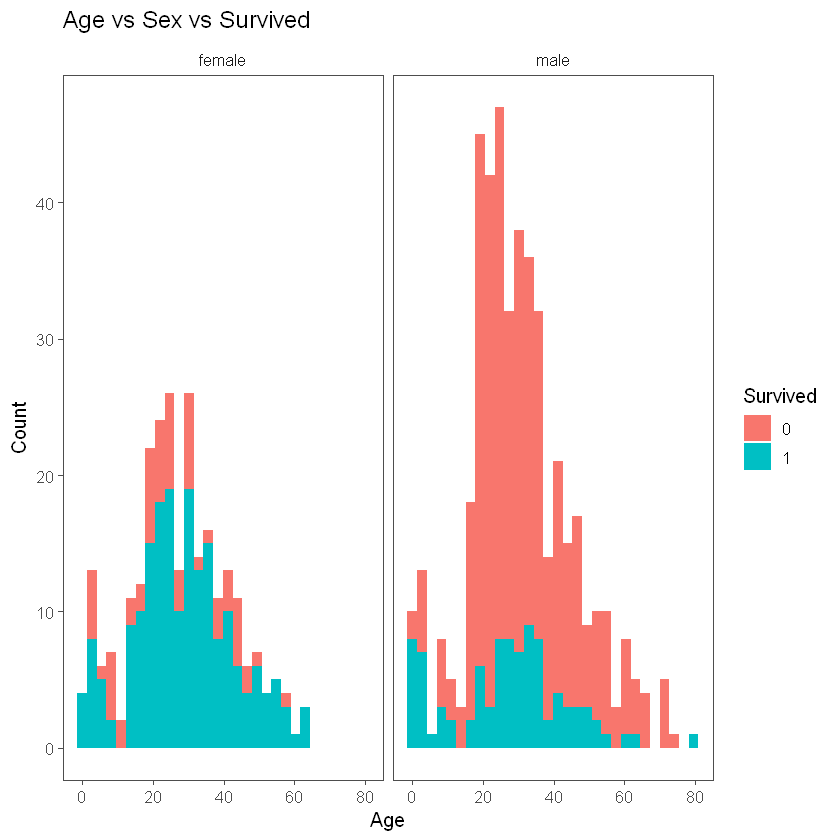

In [10]:
ggplot(full[1:891,], aes(Age, fill = factor(Survived))) + 
  geom_histogram(bins=30) + 
  theme_few() +
  xlab("Age") +
  ylab("Count") +
  facet_grid(.~Sex)+
  scale_fill_discrete(name = "Survived") + 
  theme_few()+
  ggtitle("Age vs Sex vs Survived")

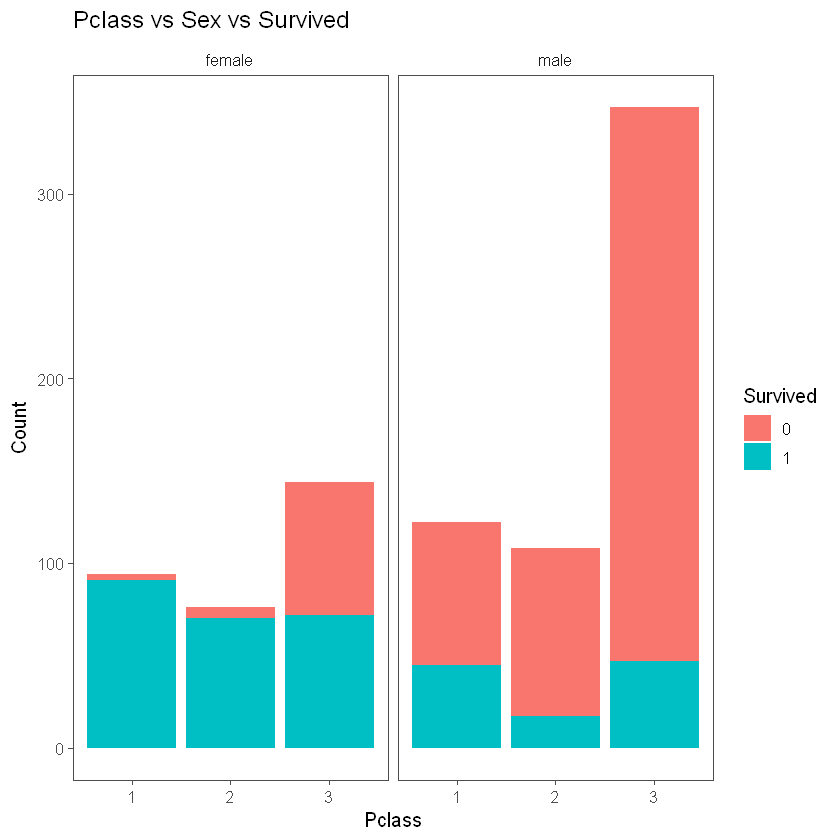

In [11]:
ggplot(full[1:891,], aes(Pclass, fill = factor(Survived))) + 
  geom_bar(stat = "count")+
  theme_few() +
  xlab("Pclass") +
  facet_grid(.~Sex)+
  ylab("Count") +
  scale_fill_discrete(name = "Survived") + 
  ggtitle("Pclass vs Sex vs Survived")

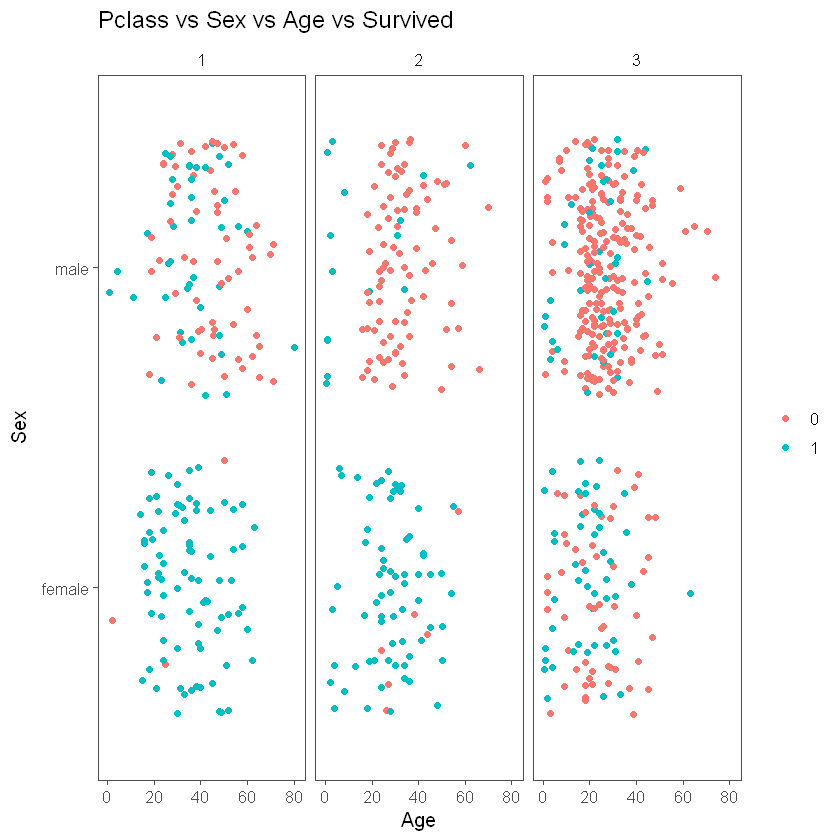

In [12]:
ggplot(full[1:891,], aes(x = Age, y = Sex)) + 
  geom_jitter(aes(colour = factor(Survived))) + 
  theme_few()+
  theme(legend.title = element_blank())+
  facet_wrap(~Pclass) + 
  labs(x = "Age", y = "Sex", title = "Pclass vs Sex vs Age vs Survived")+
  scale_fill_discrete(name = "Survived") + 
  scale_x_continuous(name="Age",limits=c(0, 81))

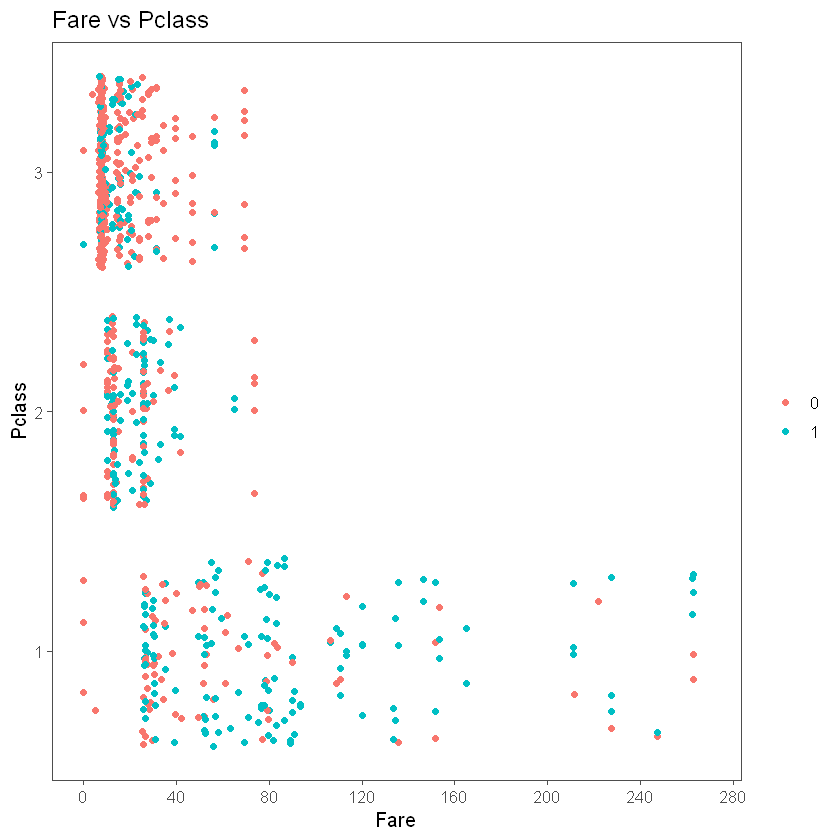

In [13]:
ggplot(full[1:891,], aes(x = Fare, y = Pclass)) + 
  geom_jitter(aes(colour = factor(Survived))) + 
  theme_few()+
  theme(legend.title = element_blank())+
  labs(x = "Age", y = "Pclass", title = "Fare vs Pclass")+
  scale_fill_discrete(name = "Survived") + 
  scale_x_continuous(name="Fare", limits=c(0, 270), breaks=c(0, 40, 80, 120, 160, 200, 240, 280))

In [14]:
full$Title <- gsub('(.*, )|(\\..*)', '', full$Name)

# Titles by Sex
table(full$Sex, full$Title)

        
         Capt Col Don Dona  Dr Jonkheer Lady Major Master Miss Mlle Mme  Mr Mrs
  female    0   0   0    1   1        0    1     0      0  260    2   1   0 197
  male      1   4   1    0   7        1    0     2     61    0    0   0 757   0
        
          Ms Rev Sir the Countess
  female   2   0   0            1
  male     0   8   1            0

In [15]:
officer <- c('Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev')
royalty <- c('Dona', 'Lady', 'the Countess','Sir', 'Jonkheer')

# Reassign mlle, ms, and mme, and rare
full$Title[full$Title == 'Mlle']        <- 'Miss' 
full$Title[full$Title == 'Ms']          <- 'Miss'
full$Title[full$Title == 'Mme']         <- 'Mrs' 
full$Title[full$Title %in% royalty]  <- 'Royalty'
full$Title[full$Title %in% officer]  <- 'Officer'

full$Surname <- sapply(full$Name,  
                       function(x) strsplit(x, split = '[,.]')[[1]][1])

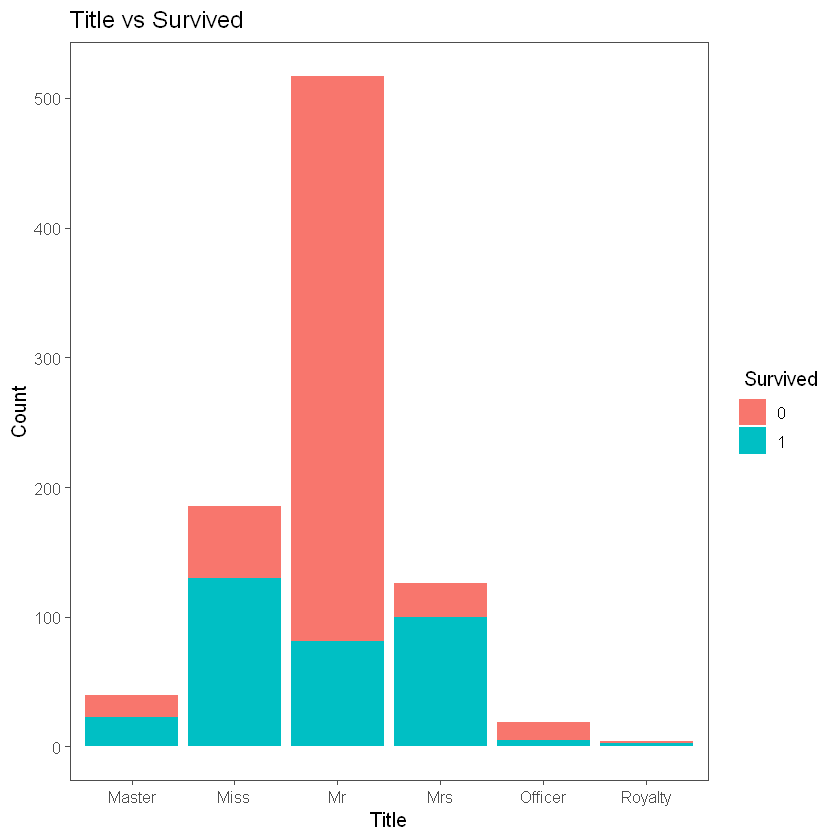

In [16]:
ggplot(full[1:891,], aes(Title,fill = factor(Survived))) +
  geom_bar(stat = "count")+
  xlab('Title') +
  ylab("Count") +
  scale_fill_discrete(name = " Survived") + 
  ggtitle("Title vs Survived")+
  theme_few()

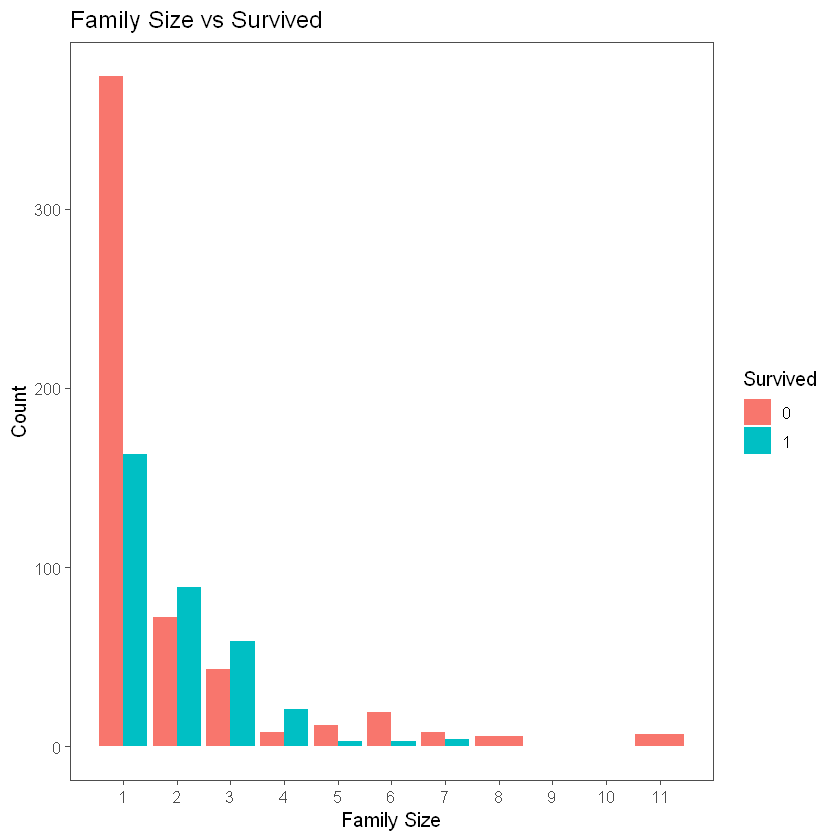

In [17]:
full$Fsize <- full$SibSp + full$Parch + 1

ggplot(full[1:891,], aes(x = Fsize, fill = factor(Survived))) +
  geom_bar(stat='count', position='dodge') +
  scale_x_continuous(breaks=c(1:11)) +
  xlab('Family Size') +
  ylab("Count") +
  theme_few()+
  scale_fill_discrete(name = "Survived") + 
  ggtitle("Family Size vs Survived")

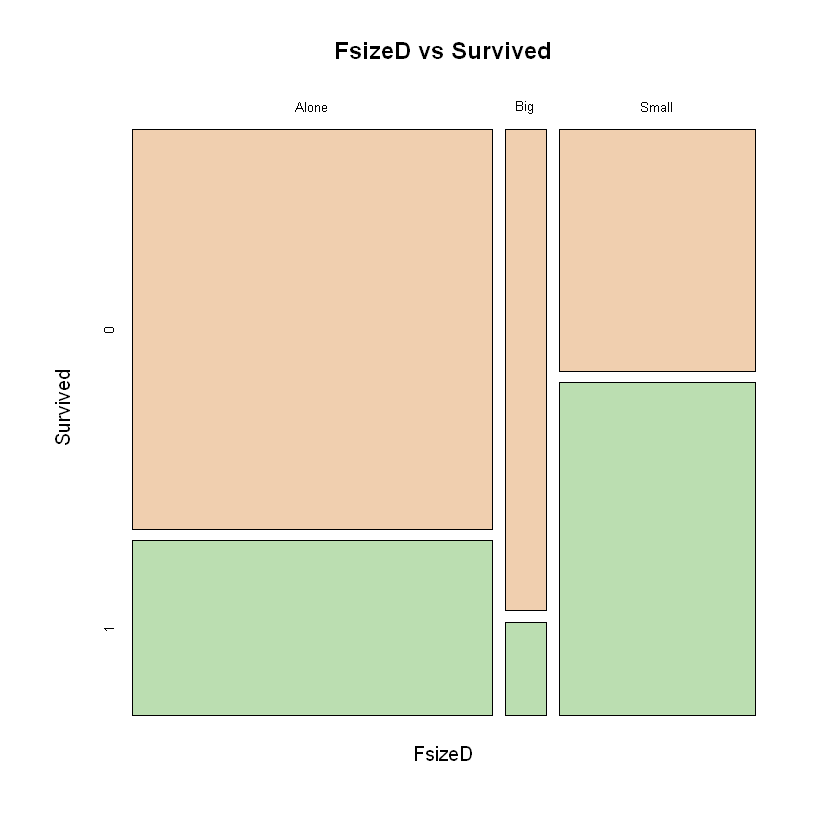

In [18]:
full$FsizeD[full$Fsize == 1] <- 'Alone'
full$FsizeD[full$Fsize < 5 & full$Fsize > 1] <- 'Small'
full$FsizeD[full$Fsize > 4] <- 'Big'

mosaicplot(table(full$FsizeD, full$Survived), main='FsizeD vs Survived', ylab="Survived",xlab="FsizeD",col = hcl(c(50, 120)),)

[1] "" ""

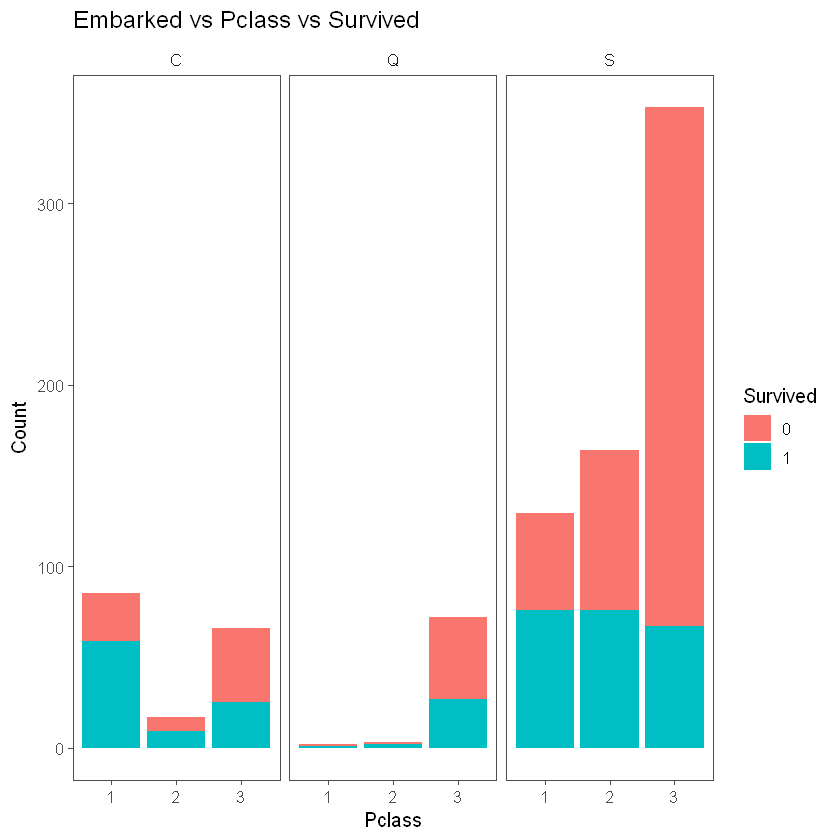

In [19]:
full[c(62, 830), 'Embarked']

full$Embarked[c(62, 830)] <- 'S'

ggplot(full[1:891,], aes(Pclass, fill = factor(Survived))) + 
  geom_bar(stat = "count")+
  theme_few() +
  xlab("Pclass") +
  ylab("Count") +
  facet_wrap(~Embarked) + 
  scale_fill_discrete(name = "Survived") + 
  ggtitle("Embarked vs Pclass vs Survived")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Surname,Fsize,FsizeD
1044,1044,NA,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NA,,S,Mr,Storey,1,Alone


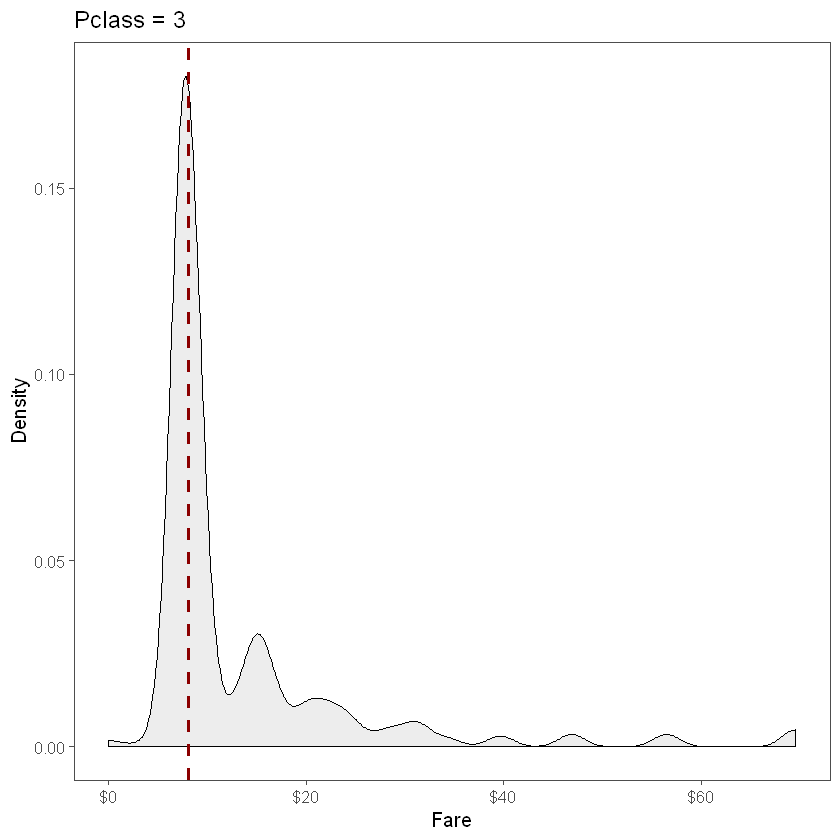

In [20]:
full[1044, ]

ggplot(full[full$Pclass == '3', ], 
       aes(x = Fare)) +
  geom_density(fill = 'lightgrey', alpha=0.4) + 
  geom_vline(aes(xintercept=median(Fare, na.rm=T)),
             colour='darkred', linetype='dashed', lwd=1) +
  xlab('Fare') +
  ggtitle("Pclass = 3")+
  ylab("Density") +
  scale_x_continuous(labels=dollar_format()) +
  theme_few()

full$Fare[1044] <- median(full[full$Pclass == '3', ]$Fare, na.rm = TRUE)

In [21]:
title.age <- aggregate(full$Age,by = list(full$Title), FUN = function(x) median(x, na.rm = T))

full[is.na(full$Age), "Age"] <- apply(full[is.na(full$Age), ] , 1, function(x) title.age[title.age[, 1]==x["Title"], 2])

#Na value count
sum(is.na(full$Age))

[1] 0

       
          0   1
  Adult 495 279
  Child  54  63

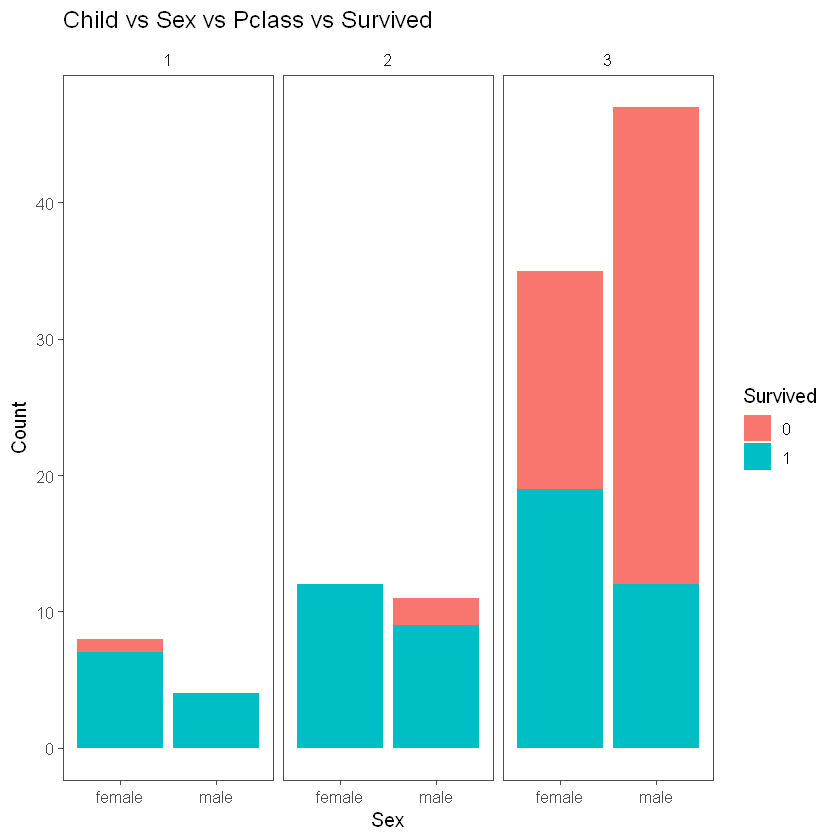

In [22]:
full$Child[full$Age < 18] <- 'Child'
full$Child[full$Age >= 18] <- 'Adult'

ggplot(full[1:891,][full[1:891,]$Child == 'Child', ], aes(Sex, fill = factor(Survived))) + 
  geom_bar(stat = "count") + 
  xlab("Sex") +
  ylab("Count") +
  facet_wrap(~Pclass)+
  scale_fill_discrete(name = "Survived") +
  ggtitle("Child vs Sex vs Pclass vs Survived")+
  theme_few()

table(full$Child, full$Survived)

In [23]:
corr_data <- full[1:891,]

## transform to numeric type and recodification
corr_data$Embarked <- revalue(corr_data$Embarked, 
                                  c("S" = 1, "Q" = 2, "C" = 3))
corr_data$Sex <- revalue(corr_data$Sex, 
                              c("male" = 1, "female" = 2))
corr_data$Title <- revalue(corr_data$Title, 
                           c("Mr" = 1, "Master" = 2,"Officer" = 3, 
                             "Mrs" = 4,"Royalty" = 5,"Miss" = 6))
corr_data$FsizeD <- revalue(corr_data$FsizeD, 
                         c("Small" = 1, "Alone" = 2, "Big" = 3))
corr_data$Child <- revalue(corr_data$Child, 
                            c("Adult" = 1, "Child" = 2))
corr_data$FsizeD <- as.numeric(corr_data$FsizeD)
corr_data$Child <- as.numeric(corr_data$Child)
corr_data$Sex <- as.numeric(corr_data$Sex)
corr_data$Embarked <- as.numeric(corr_data$Embarked)
corr_data$Title <- as.numeric(corr_data$Title)
corr_data$Pclass <- as.numeric(corr_data$Pclass)
corr_data$Survived <- as.numeric(corr_data$Survived)

corr_data <-corr_data[,c("Survived", "Pclass", "Sex", 
               "FsizeD", "Fare", "Embarked","Title","Child")]

str(corr_data)

'data.frame':	891 obs. of  8 variables:
 $ Survived: num  0 1 1 1 0 0 0 0 1 1 ...
 $ Pclass  : num  3 1 3 1 3 3 1 3 3 2 ...
 $ Sex     : num  1 2 2 2 1 1 1 1 2 2 ...
 $ FsizeD  : num  1 1 2 1 2 2 2 3 1 1 ...
 $ Fare    : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Embarked: num  1 3 1 1 1 2 1 1 1 3 ...
 $ Title   : num  1 4 6 4 1 1 1 2 4 4 ...
 $ Child   : num  1 1 1 1 1 1 1 2 1 2 ...


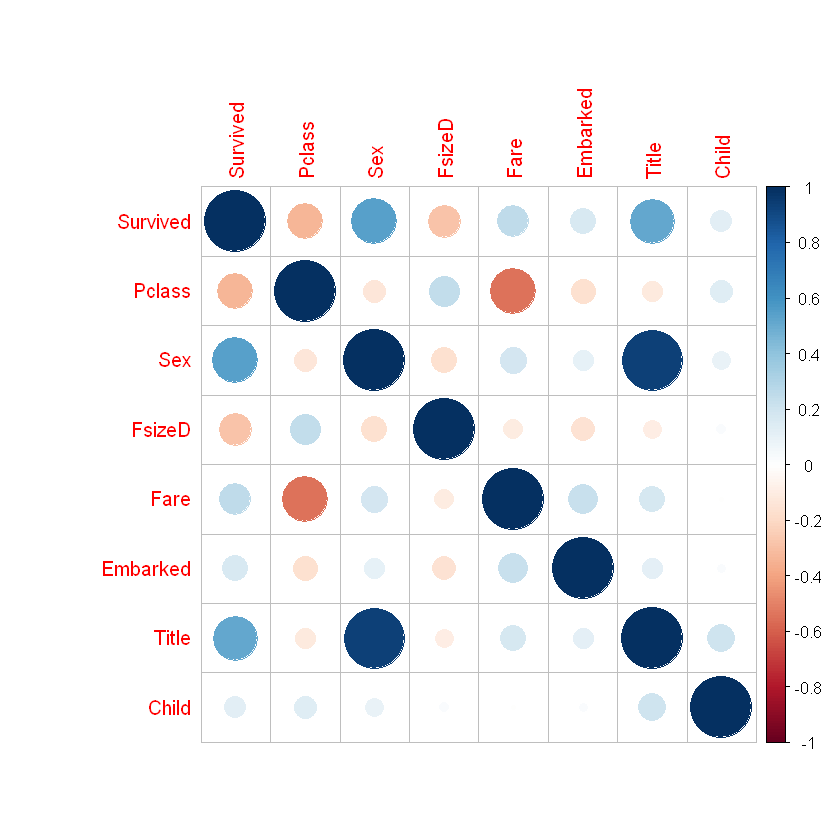

In [24]:
mcorr_data <- cor(corr_data)

corrplot(mcorr_data,method="circle")

In [25]:
full$Child  <- factor(full$Child)
full$Sex  <- factor(full$Sex)
full$Embarked  <- factor(full$Embarked)
full$Title  <- factor(full$Title)
full$Pclass  <- factor(full$Pclass)
full$FsizeD  <- factor(full$FsizeD)

#___________________________Data without Cabin & Ticket __________________________

full1 <- full[,-9]
full_mod <- full1[,-10]

In [26]:
train <- full_mod[1:891,]
test <- full_mod[892:1309,]

# random forest
library('randomForest')

set.seed(123)
rf_model <- randomForest(factor(Survived) ~ Pclass + Sex + Fare + Embarked + Title + 
                           FsizeD + Child, data = train)

In [27]:
rf.fitted = predict(rf_model)
ans_rf = rep(NA,891)
for(i in 1:891){
  ans_rf[i] = as.integer(rf.fitted[[i]]) - 1
}
# Résultat
table(ans_rf)

print(rf_model)

ans_rf
  0   1 
608 283 


Call:
 randomForest(formula = factor(Survived) ~ Pclass + Sex + Fare +      Embarked + Title + FsizeD + Child, data = train) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 2

        OOB estimate of  error rate: 16.72%
Confusion matrix:
    0   1 class.error
0 504  45  0.08196721
1 104 238  0.30409357


In [28]:
prediction <- predict(rf_model, test)

# Solution 2 columns (prediction)
solution <- data.frame(Survived = prediction, PassengerID = test$PassengerId)

# .csv
write.csv(solution, file = 'rf_model_sol.csv', row.names = F)

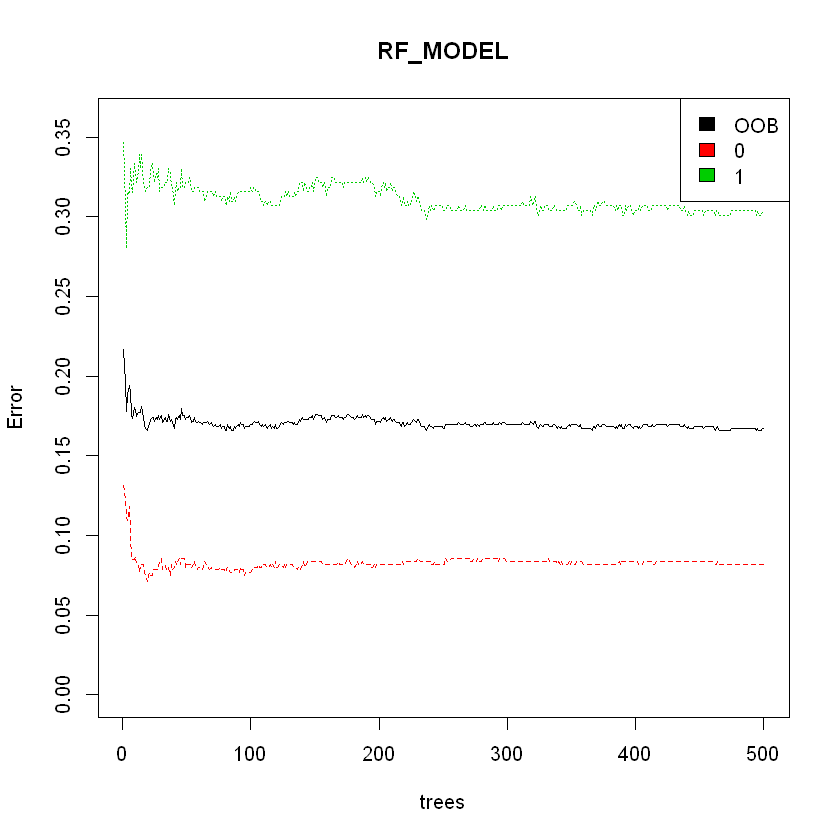

In [29]:
plot(rf_model, ylim=c(0,0.36), main = 'RF_MODEL')
legend('topright', colnames(rf_model$err.rate), col=1:3, fill=1:3)

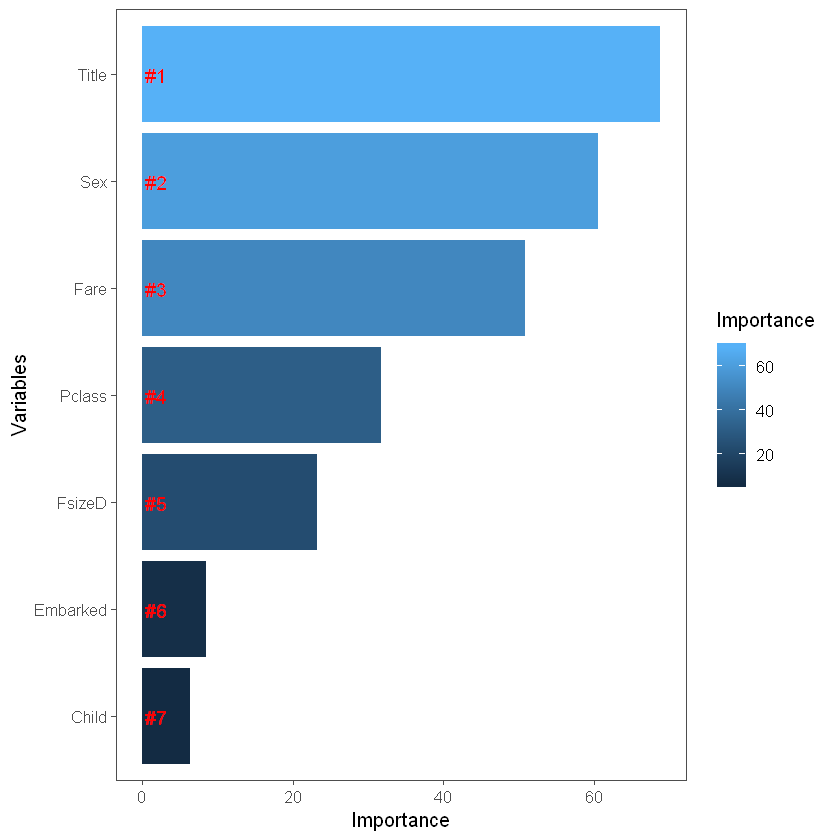

In [30]:
importance    <- importance(rf_model)
varImportance <- data.frame(Variables = row.names(importance), 
                            Importance = round(importance[ ,'MeanDecreaseGini'],2))

# var imp
rankImportance <- varImportance %>%
  mutate(Rank = paste0('#',dense_rank(desc(Importance))))

# Graph var importantes
ggplot(rankImportance, aes(x = reorder(Variables, Importance), 
                           y = Importance, fill = Importance)) +
  geom_bar(stat='identity') + 
  geom_text(aes(x = Variables, y = 0.5, label = Rank),
            hjust=0, vjust=0.55, size = 4, colour = 'red') +
  labs(x = 'Variables') +
  coord_flip() + 
  theme_few()